In [1]:
!pip install --upgrade pip
!pip3 install torch torchvision torchaudio
!pip install datasets timm einops transformers pillow huggingface_hub flash_attn

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import torch

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

m = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

In [6]:
prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)


In [32]:
image = Image.open("/teamspace/studios/this_studio/Aug_Label/notebooks/images/yolo_dog.jpg")  

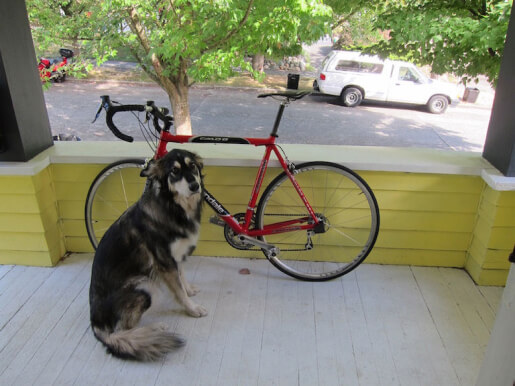

In [33]:
image

In [44]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
text_input="dog"
prompt = task_prompt + text_input
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OPEN_VOCABULARY_DETECTION>", image_size=(image.width, image.height))

print(parsed_answer)


{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[87.29249572753906, 148.031005859375, 210.3774871826172, 362.6470031738281]], 'bboxes_labels': ['dog'], 'polygons': [], 'polygons_labels': []}}


In [45]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

In [46]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

In [47]:
bbox_results  = convert_to_od_format(parsed_answer['<OPEN_VOCABULARY_DETECTION>'])

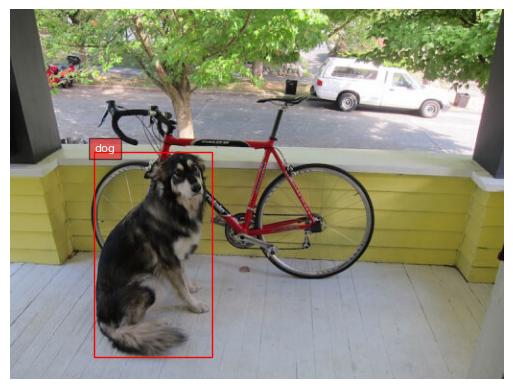

In [48]:
plot_bbox(image, bbox_results)